In [1]:
import logging
logging.basicConfig(level=logging.INFO)

import sys
import random
sys.path.insert(0, "D:/IIT/DDP/DDP/B-SOID")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from new_clustering import *
from joblib import Parallel, delayed

In [6]:
data_dir = "../../../data/2clustering"
with open(os.path.join(data_dir, "strainwise_labels.sav"), "rb") as f:
    feats, embedding, labels = joblib.load(f)
with open(os.path.join(data_dir, "pairwise_sim.sav"), "rb") as f:
    sim, thresh = joblib.load(f)
feats = collect_strainwise_feats(feats)

# Try Similarity Measures

In [12]:
clusters = collect_strainwise_clusters(feats, labels, embedding, thresh=0.9)

strain2idx = {}
for cluster_idx in clusters.keys():
    strain = cluster_idx.split(':')[0]
    if strain in strain2idx:
        strain2idx[strain].append(cluster_idx)
    else:
        strain2idx[strain] = [cluster_idx]

INFO:new_clustering:Strain: 129P3/J ; Features: (53990, 56) ; Embedding: (53990, 25) ; Labels: (53990,)
INFO:new_clustering:Strain: 129S1/SvlmJ ; Features: (53990, 56) ; Embedding: (53990, 25) ; Labels: (53990,)
INFO:new_clustering:Strain: 129X1/SvJ ; Features: (53990, 56) ; Embedding: (53990, 25) ; Labels: (53990,)
INFO:new_clustering:Strain: A/J ; Features: (53990, 56) ; Embedding: (53990, 25) ; Labels: (53990,)
INFO:new_clustering:Strain: AKR/J ; Features: (53990, 56) ; Embedding: (53990, 25) ; Labels: (53990,)
INFO:new_clustering:Strain: B6129PF1/J ; Features: (53990, 56) ; Embedding: (53990, 25) ; Labels: (53990,)
INFO:new_clustering:Strain: B6129SF1/J ; Features: (53990, 56) ; Embedding: (53990, 25) ; Labels: (53990,)
INFO:new_clustering:Strain: B6AF1/J ; Features: (53990, 56) ; Embedding: (53990, 25) ; Labels: (53990,)
INFO:new_clustering:Strain: B6C3F1/J ; Features: (53990, 56) ; Embedding: (53990, 25) ; Labels: (53990,)
INFO:new_clustering:Strain: B6CBAF1/J ; Features: (53990,

INFO:new_clustering:pooling 37 clusters from CAST/EiJ with entropy ratio 0.9465124692380738
INFO:new_clustering:pooling 30 clusters from CB6F1/J with entropy ratio 0.9056915193914004
INFO:new_clustering:pooling 37 clusters from CBA/CaJ with entropy ratio 0.9444063896442496
INFO:new_clustering:pooling 56 clusters from CBA/J with entropy ratio 0.9570471353303639
INFO:new_clustering:pooling 40 clusters from CByB6F1/J with entropy ratio 0.9457929476865081
INFO:new_clustering:pooling 64 clusters from CZECHII/EiJ with entropy ratio 0.9283137047167646
INFO:new_clustering:pooling 60 clusters from DBA/2J with entropy ratio 0.9494678246000532
INFO:new_clustering:pooling 23 clusters from FVB/NJ with entropy ratio 0.9460221991309016
INFO:new_clustering:pooling 80 clusters from I/LnJ with entropy ratio 0.9651370890021475
INFO:new_clustering:pooling 9 clusters from KK/HiJ with entropy ratio 0.9274716379643939
INFO:new_clustering:pooling 60 clusters from LG/J with entropy ratio 0.9322273184814311
INF

In [ ]:
from numba import njit
@njit
def cdist2val(D):
    m,n = D.shape
    result = 0.0
    for i in range(m):
        for j in range(i,n):
            result += D[i,j]
    return result / (m * n)

from scipy.spatial.distance import cdist, directed_hausdorff
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import calinski_harabasz_score
def cluster_similarity(cluster1, cluster2):
    X1, X2 = np.copy(cluster1["feats"]), np.copy(cluster2["feats"])
    y = np.hstack((np.zeros((X1.shape[0],)), np.ones((X2.shape[0],))))
    X = np.vstack((X1, X2))

#     model = LinearDiscriminantAnalysis().fit(X, y)
#     X1proj, X2proj = model.transform(X1), model.transform(X2)
    
#     D = cdist(X1proj, X2proj, metric="mahalanobis")
    return calinski_harabasz_score(X, y)

In [ ]:
strain2clusters = {}
for clusterid in clusters.keys():
    strain = clusterid.split(':')[0]
    if strain in strain2clusters:
        strain2clusters[strain].append(clusterid)
    else:
        strain2clusters[strain] = [clusterid]

strain = random.sample(list(strain2clusters.keys()), 1)[0]
wthin_strain = Parallel(n_jobs=6)(delayed(cluster_similarity)(clusters[clusteridx1], clusters[clusteridx2]) for clusteridx1, clusteridx2 in combinations(strain2clusters[strain], 2)) 

strain1, strain2 = random.sample(list(strain2clusters.keys()), 2)
bween_strain = []
for clusteridx1 in strain2clusters[strain1]:
    for clusteridx2 in strain2clusters[strain2]:
        bween_strain.append(cluster_similarity(clusters[clusteridx1], clusters[clusteridx2]))
wthin_strain, bween_strain = np.array(wthin_strain), np.array(bween_strain)

In [ ]:
sns.displot(wthin_strain)

In [ ]:
sns.displot(bween_strain)

In [ ]:
def plot_random_strain(thresh):
    while True:
        strain = random.sample(list(strain2idx.keys()), 1)[0]
        X = [clusters[cluster_idx]["feats"] for cluster_idx in strain2idx[strain]]
        y = [i * np.ones((x.shape[0],)) for i, x in enumerate(X)]
        X, y = np.vstack(X), np.hstack(y)
        counts = np.unique(y, return_counts=True)[1]
        prop = [x / y.size for x in counts]
        entropy_ratio = -sum(p * np.log2(p) for p in prop) / max_entropy(len(prop))
        if entropy_ratio >= thresh:
            print(f"found: {strain} with entropy: {entropy_ratio}")
            break
    
    mapper = umap.UMAP(min_dist=0.0, n_neighbors=500, n_components=2, densmap=True).fit(StandardScaler().fit_transform(X))
    embed = mapper.embedding_
    _, _, glabels, _ = cluster_with_hdbscan(embed, [0.5, 1.0, 11], {"prediction_data": True, "min_samples": 1})
    
    plt.figure(figsize=(10,10))
    plt.scatter(embed[:,0], embed[:,1], c=glabels, cmap="Spectral", s=0.2, alpha=0.75)
    plt.show()

In [ ]:
plot_random_strain(0.9)

# Trim identified clusters

In [ ]:
def get_entropy_ratio_for_strain(strain, clusters):
    counts = []
    for cluster_id, data in clusters.items():
        if cluster_id.split(':')[0] == strain:
            counts.append(data["feats"].shape[0])
    
    prop = [x / sum(counts) for x in counts]
    entropy_ratio = -sum(p * np.log2(p) for p in prop) / max_entropy(len(counts))

    return entropy_ratio

def trim_clusters(clusters, sim_mat, thresh):
    # find strains below threshold
    strains = list(set([cluster_id.split(':')[0] for cluster_id in clusters.keys()]))
    remove_strains = [strain for strain in strains if get_entropy_ratio_for_strain(strain, clusters) < thresh]
    
    # find cluster idxs to be retained/removed
    retain_k, retain_cluster_ids = [], []
    for cluster_id in clusters.keys():
        strain, _, k = cluster_id.split(':')
        if strain not in remove_strains:
            retain_k.append(int(k))
            retain_cluster_ids.append(cluster_id)
    
    print(f"Retained {len(retain_cluster_ids)} out of {len(clusters)} clusters")
    
    sim_mat = sim_mat[:,retain_k]
    sim_mat = sim_mat[retain_k,:]
    
    idxmap = {k: i for i, k in enumerate(sorted(retain_k))}
    clusters = {cluster_id: clusters[cluster_id] for cluster_id in retain_cluster_ids}
    new_clusters = {}
    for cluster_id, data in clusters.items():
        strain, idx, k = cluster_id.split(':')
        new_clusters[f"{strain}:{idx}:{idxmap[int(k)]}"] = data

    return sim_mat, new_clusters

# Grouping Analysis

In [ ]:
def embed_and_group_clusters(sim_mat):
    mapper = umap.UMAP(min_dist=0.0, n_neighbors=50, n_components=2).fit(sim_mat)
    assgn, _, glabels, _ = cluster_with_hdbscan(mapper.embedding_, [1.5, 3], HDBSCAN_PARAMS)
    
    embed = mapper.embedding_[assgn >= 0]
    plt.scatter(embed[:,0], embed[:,1], c=glabels[assgn >= 0], s=5, cmap="Spectral")
    plt.show(){}
    
    return glabels

def same_strain_grouping_frac(glabels, clusters):
    cluster2group = {k: lab for k, lab in enumerate(glabels)}
    group_frac = {}
    for cluster_id in clusters.keys():
        strain, _, k = cluster_id.split(':')
        if strain in group_frac:
            group_frac[strain].append(cluster2group[int(k)])
        else:
            group_frac[strain] = [cluster2group[int(k)]]
    group_frac = {strain: round(np.unique(labs).size / len(labs), 2) for strain, labs in group_frac.items()}
    return group_frac

def avg_group_sim(glabels, clusters, sim_mat):
    group_sim = {}
    for k, lab in enumerate(glabels):
        if lab in group_sim:
            group_sim[lab].append(k)
        else:
            group_sim[lab] = [k]
    
    within_group_sim = {}
    for group, cluster_idx in group_sim.items():
        within_group_sim[group] = np.array([sim_mat[i,j] for i, j in combinations(cluster_idx, 2)]).mean()
    
    n = glabels.max() + 1
    between_group_sim = np.zeros((n, n))
    for i, j in combinations(list(group_sim.keys()), 2):
        avg_sim = []
        for cluster1 in group_sim[i]:
            for cluster2 in group_sim[j]:
                avg_sim.append(sim_mat[cluster1, cluster2])
        between_group_sim[i,j] = between_group_sim[j,i] = np.array(avg_sim).mean()
    
    between_group_sim = np.abs(between_group_sim - 0.5) + 0.5
    return within_group_sim, between_group_sim

## w/o NN imputing

In [ ]:
clusters = collect_strainwise_clusters(feats, labels, embedding, thresh)
tsim, tclusters = trim_clusters(clusters, similarity_matrix(sim), thresh=0.5)
no_impute_glabs = embed_and_group_clusters(tsim)
no_impute_group_frac = same_strain_grouping_frac(no_impute_glabs, tclusters)
no_impute_wgs, no_impute_bgs = avg_group_sim(no_impute_glabs, tclusters, tsim)

## w/ NN imputing

In [ ]:
clusters = collect_strainwise_clusters(feats, labels, embedding, thresh)
imputing_sim = impute_same_strain_values(sim, clusters)
impute_tsim, impute_tclusters = trim_clusters(clusters, similarity_matrix(imputing_sim), thresh=0.5)
impute_glabs = embed_and_group_clusters(impute_tsim)
impute_group_frac = same_strain_grouping_frac(impute_glabs, impute_tclusters)
impute_wgs, impute_bgs = avg_group_sim(impute_glabs, impute_tclusters, impute_tsim)

In [ ]:
group_frac = {"strain": [], "type": [], "frac": []}
for strain in impute_group_frac.keys():
    group_frac["strain"].extend([strain, strain])
    group_frac["type"].append("impute")
    group_frac["frac"].append(impute_group_frac[strain])
    group_frac["type"].append("no impute")
    group_frac["frac"].append(no_impute_group_frac[strain])
group_frac = pd.DataFrame.from_dict(group_frac)

plt.figure(figsize=(5, 10))
sns.barplot(x="frac", y="strain", hue="type", data=group_frac)
plt.plot([0.5, 0.5], plt.ylim(), "--", c="0.8")
plt.title("Strainwise Grouping Fraction")
plt.show()

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

axs[0][0].barh(list(no_impute_wgs.keys()), [x for _, x in no_impute_wgs.items()])
axs[0][0].plot([0.5, 0.5], axs[0][0].get_ylim(), '--', color='0.8')
axs[1][0].barh(list(impute_wgs.keys()), [x for _, x in impute_wgs.items()])
axs[1][0].plot([0.5, 0.5], axs[1][0].get_ylim(), '--', color='0.8')
sns.heatmap(no_impute_bgs, ax=axs[0][1])
sns.heatmap(impute_bgs, ax=axs[1][1])
plt.show()

In [ ]:
M = similarity_matrix(sim)

In [ ]:
import cv2
cv2.imshow("heatmap", M)
cv2.waitKey(0)

In [ ]:
from sklearn.datasets import make_blobs
n = 22
centers = np.vstack((np.zeros(2,), np.ones(2,)))
X, y = make_blobs([2000, 500], n, centers=centers, cluster_std=1, shuffle=True)
model = LinearDiscriminantAnalysis().fit(X,y)
Xproj = model.transform(X)

plt.scatter(Xproj, np.zeros_like(Xproj), c=y, s=1)
plt.show()

In [ ]:
mapped = umap.UMAP(n_components=2, n_neighbors=10, min_dist=0.0, metric="precomputed").fit_transform(sim_mat)
labels, _, glabels, _ = cluster_with_hdbscan(mapped, [0.5, 2.5], {"prediction_data": True, "min_samples": 1})
idx, counts = np.unique(glabels, return_counts=True)
plt.barh(idx, counts)
plt.show()

In [ ]:
plt.scatter(mapped[:,0], mapped[:,1], s=0.5, c=glabels, cmap="Set1")
plt.show()

# Analyze Strain Data

In [87]:
strain = random.sample(list(labels.keys()), 1)[0]
embed = umap.UMAP(n_components=2, n_neighbors=90, min_dist=0.0).fit_transform(StandardScaler().fit_transform(feats[strain]))

strainwise_cluster_rng = [0.4, 1.2, 25]
hdbscan_params = {"prediction_data": True, "min_samples": 1, "core_dist_n_jobs": 1}
labs, _, assgn, clusterer = cluster_with_hdbscan(embedding[strain], strainwise_cluster_rng, hdbscan_params)

INFO:root:identified 45 clusters (max is 45) with min_sample_prop=0.4 and entropy_ratio=0.906
INFO:root:identified 40 clusters (max is 45) with min_sample_prop=0.43 and entropy_ratio=0.914
INFO:root:identified 38 clusters (max is 45) with min_sample_prop=0.47 and entropy_ratio=0.916
INFO:root:identified 37 clusters (max is 45) with min_sample_prop=0.5 and entropy_ratio=0.919
INFO:root:identified 35 clusters (max is 45) with min_sample_prop=0.53 and entropy_ratio=0.92
INFO:root:identified 35 clusters (max is 45) with min_sample_prop=0.57 and entropy_ratio=0.92
INFO:root:identified 32 clusters (max is 45) with min_sample_prop=0.6 and entropy_ratio=0.919
INFO:root:identified 30 clusters (max is 45) with min_sample_prop=0.63 and entropy_ratio=0.917
INFO:root:identified 31 clusters (max is 45) with min_sample_prop=0.67 and entropy_ratio=0.924
INFO:root:identified 29 clusters (max is 45) with min_sample_prop=0.7 and entropy_ratio=0.918
INFO:root:identified 27 clusters (max is 45) with min_sa

<IPython.core.display.Javascript object>


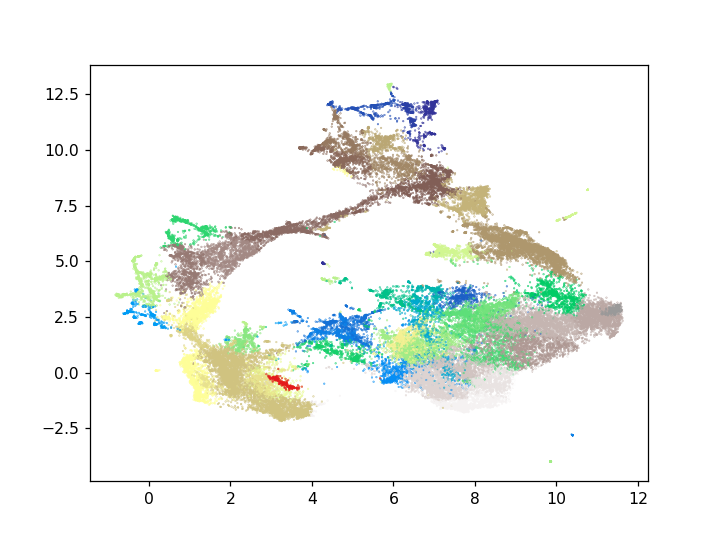

In [102]:
plt.scatter(embed[:,0], embed[:,1], s=0.1, c=assgn, cmap="terrain")
plt.show()

In [104]:
exem_idxs = clusterer.exemplars_indices_

min_metric, max_metric = 2, -2
all_vals = []
for cluster1, cluster2 in combinations(range(len(exem_idxs)), 2):
    idxs = np.hstack([exem_idxs[cluster1], exem_idxs[cluster2]])
    val = validity_index(feats[strain][idxs], assgn[idxs], metric="cosine")
    all_vals.append(val)
    if val < min_metric:
        min_metric = val
        min_pair = [cluster1, cluster2]
    if val > max_metric:
        max_metric = val
        max_pair = [cluster1, cluster2]

from hdbscan.validity import validity_index
print(min_metric, max_metric)

-0.95069474896837 0.9760660544757789


In [101]:
min_idxs = np.hstack([exem_idxs[min_pair[0]], exem_idxs[min_pair[1]]])
plt.scatter(embed[min_idxs,0], embed[min_idxs,1], s=0.1, c=assgn[min_idxs], cmap="Set1")
plt.show()

In [103]:
max_idxs = np.hstack([exem_idxs[max_pair[0]], exem_idxs[max_pair[1]]])
plt.scatter(embed[max_idxs,0], embed[max_idxs,1], s=0.1, c=assgn[max_idxs], cmap="Set1")
plt.show()

In [99]:
from scipy.spatial.distance import cdist
metric = "cosine"

pair = max_pair
print(cdist(feats[strain][exem_idxs[pair[0]]], feats[strain][exem_idxs[pair[1]]], metric=metric).min())

pair = min_pair
print(cdist(feats[strain][exem_idxs[pair[0]]], feats[strain][exem_idxs[pair[1]]], metric=metric).min())

0.1539894863574115
0.0002642338176657155
